## ML Model ohne Wetter-Variablen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate,StratifiedKFold, cross_val_score, train_test_split
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

In [9]:
#read data scikit-learn
os.chdir('C:/Users/Katharina/Desktop/Weiterbildung/Bootcamp/Bootcamp/Final_project/data')
#data = pd.read_csv('DatenML_V2_relCol.csv', sep=';')
data = pd.read_csv('DatenML_V2_relCol_ZusatzType.csv', sep=';')	

In [10]:
df = data
# Erstellen der neuen Spalte "Team1":
# Wenn TeamDesignation = A, dann soll TeamAName in Team1 stehen,
# andernfalls (also bei B) TeamBName.
df["Team1"] = np.where(
    df["TeamDesignation"].str.upper() == "A",
    df["@TeamAName"],
    df["@TeamBName"]
)

# Erstellen der Spalte "Team2" als das jeweils andere Team:
df["Team2"] = np.where(
    df["TeamDesignation"].str.upper() == "A",
    df["@TeamBName"],
    df["@TeamAName"]
)

In [12]:
#bestimmte Variablen entfernen
#wetter variablen entfernen
# data1 = df.drop(['FirstName', 'LastName','total_A', 'total_B', 'TeamDesignation','@PointsTeamASet1', '@PointsTeamBSet1', '@PointsTeamASet2',
#        '@PointsTeamBSet2', '@PointsTeamASet3', '@PointsTeamBSet3', 'temperature_2m',
#        'precipitation', 'wind_speed_10m', 'rain', 'wind_gusts_10m',
#        'FederationCode_y', '@TeamAName', '@TeamBName','Gender_x','TeamName',
#        '@DurationSet1','@LocalDate', '@LocalTime',
#        '@DurationSet2', '@DurationSet3'], axis=1)

#bestimmte Variablen entfernen
data1 = df.drop(['FirstName', 'LastName', 'TeamDesignation','@PointsTeamASet1', '@PointsTeamBSet1', '@PointsTeamASet2',
       '@PointsTeamBSet2', '@PointsTeamASet3', '@PointsTeamBSet3', 
       'FederationCode_y', '@TeamAName', '@TeamBName',
       '@DurationSet1','@LocalDate', '@LocalTime','temperature_2m',
       'precipitation', 'wind_speed_10m', 'rain', 'wind_gusts_10m',
       #neu
       'FirstName2', 'LastName2','Type','TournamentNo','NoPlayer1_team', 'NoPlayer2_team',#'total_A', 'total_B', 'TeamName'-> nicht mehr da
       '@DurationSet2', '@DurationSet3'], axis=1)
#'Gender_x',

In [13]:
y = data1.pop('match_win')
X = data1.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3146)

In [17]:
#abspeichern für streamlit app
df.to_csv('ML_MatchWin_OHNEWeather_V2.csv', index=False, sep=';')

In [15]:
# select categorical and numerical column names
nominal_features = X.select_dtypes(include=['object']).columns.tolist()
# Define feature types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessors for different feature types
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Build the column transformer
transformers = [
    ('num', numeric_transformer, numeric_features),
    ('nom', nominal_transformer, nominal_features)
]

preprocessor = ColumnTransformer(transformers=transformers)

In [10]:
#Model Building
# Define models
models = {
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=200, max_depth=15, 
                                         min_samples_split=5, min_samples_leaf=2),
     'GradientBoosting': GradientBoostingClassifier(random_state=42, n_estimators=200, learning_rate=0.1, 
                                                  max_depth=5, subsample=0.8)
}

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Function to train and evaluate models
def evaluate_model(name, model, X, y, cv):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Cross-validation scores
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    
    print(f"{name} - Cross-validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    # Train on full dataset for feature importance
    pipeline.fit(X, y)
    
    return pipeline


Training RandomForest...
RandomForest - Cross-validation Accuracy: 0.8336 (±0.0106)

Training GradientBoosting...
GradientBoosting - Cross-validation Accuracy: 0.8631 (±0.0030)

Top 20 most important features:
                         Feature  Importance
4                     ServeTotal    0.465544
0                     SpikeFault    0.168803
9                     SpikeTotal    0.097765
8                 ReceptionFault    0.039548
10                TeamFault_team    0.027376
1                     SpikePoint    0.023942
5                     BlockPoint    0.021099
2                     ServeFault    0.017775
3                     ServePoint    0.014304
6                     BlockTotal    0.010351
7                       DigTotal    0.008121
1134     Team2_Perusic/Schweiner    0.001672
343        Team1_Krattiger/Breer    0.001454
1099  Team2_Nicolaidis/Carracher    0.001312
1246           Team2_Stam/Schoon    0.001086
720            Team2_Anouk/Mäder    0.000987
770       Team2_Brouwer/

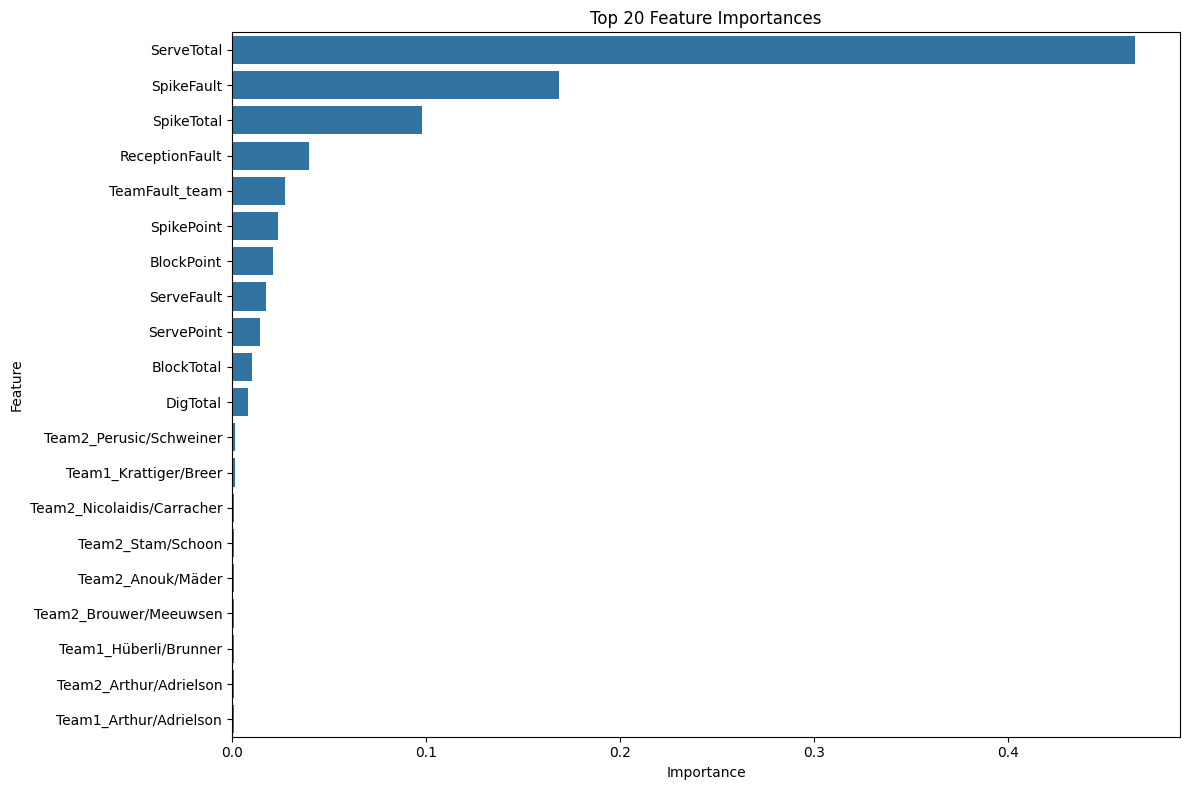

In [11]:
# Evaluate all models
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline = evaluate_model(name, model, X, y, cv)
    trained_models[name] = pipeline

# Get feature importance from one of the tree-based models (e.g., Random Forest)
rf_model = trained_models['GradientBoosting']
preprocessed_X = rf_model.named_steps['preprocessor'].transform(X)

# Get feature names after preprocessing
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    elif name == 'nom':
        ohe = trans.named_steps['onehot']
        feature_names.extend([f"{col}_{cat}" for col in cols 
                            for cat in ohe.categories_[cols.index(col)]])
    else:  # ordinal features
        feature_names.append(name[4:])  # Remove 'ord_' prefix

# Get and display feature importances
if hasattr(rf_model.named_steps['classifier'], 'feature_importances_'):
    importances = rf_model.named_steps['classifier'].feature_importances_
    
    # Create DataFrame with feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names[:len(importances)],  # Ensure lengths match
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print("\nTop 20 most important features:")
    print(importance_df.head(20))
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()

## Modelle einzeln berechnen für Streamlit app

In [16]:
#RandomForestClassifier
pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, n_estimators=200, max_depth=15, 
                                         min_samples_split=5, min_samples_leaf=2))
    ])

rf = pipeline.fit(X_train, y_train)
# Trainieren der Pipeline
pipeline.fit(X_train, y_train)

# Vorhersagen
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
import joblib
# Modell speichern als .pkl-Datei
joblib.dump(rf, "random_forest_model_ohneWetter_V2.pkl")
#################################################################
#Gradient Boosting
pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42, n_estimators=200, learning_rate=0.1, 
                                                  max_depth=5, subsample=0.8))
])

GB = pipeline2.fit(X_train, y_train)
# Trainieren der Pipeline
pipeline2.fit(X_train, y_train)

# Vorhersagen
y_pred2 = pipeline2.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)

print(f"Model Accuracy: {accuracy2:.4f}")

# Vorhersagen auf den Trainingsdaten
y_train_pred2 = GB.predict(X_train)

# Accuracy auf Trainingsdaten
train_acc2 = accuracy_score(y_train, y_train_pred2)
print(f"Trainings-Accuracy: {train_acc2:.2f}")

#abspeichern
joblib.dump(GB, "GradientBoosting_model_ohneWetter_V2.pkl")


Model Accuracy: 0.8047
Model Accuracy: 0.8629
Trainings-Accuracy: 0.94


['GradientBoosting_model_ohneWetter_V2.pkl']